In [1]:
try:
    from linclab_utils import plot_utils
except ImportError as err:
    !pip install -q git+https://github.com/linclab/linclab_utils.git
    from linclab_utils import plot_utils

In [2]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
plot_utils.linclab_plt_defaults(font="Arial", fontdir="fonts")
from matplotlib.pyplot import cm
import re
import math
import matplotlib.gridspec as gridspec

In [3]:
api = wandb.Api(timeout=19)

In [4]:
# Fetch runs for a specific project
def fetch_runs(api, entity, project_name, filters, order=None):
    if order:
        runs = api.runs(f"{entity}/{project_name}", filters=filters, order=order)
    else:
        runs = api.runs(f"{entity}/{project_name}", filters=filters)
    #print(f"Runs for project '{project_name}':")
    return runs

In [5]:
def same_config(config1, config2, keys=['normtype']):
    for key in keys:
        if config1[key] != config2[key]:
            return False
    return True

In [6]:
bright_factor = 0.75
runs_dict = dict()
runs_dict["runs_vanilla_dann"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_NAISYS', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bright_factor, "config.homeostasis": 0, "config.normtype": 0,
                                                            "config.use_testset": True}, order="-summary_metrics.test_acc")
runs_dict["runs_vanilla_dann_layernorm"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_NAISYS', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bright_factor, "config.homeostasis": 0, "config.normtype": 1,
                                                            "config.use_testset": True}, order="-summary_metrics.test_acc")
runs_dict["runs_homeostasis"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_NAISYS', filters={"config.dataset": "fashionmnist", 
                                                                "config.brightness_factor": bright_factor,"config.homeostasis": 1, "config.normtype": 0,
                                                                "config.use_testset": True, "config.task_opt_inhib": 1, "config.use_sep_bias_gain_lrs": 0,
                                                                "config.homeostatic_annealing": 0, "config.implicit_homeostatic_loss": 0 }, order="-summary_metrics.test_acc")

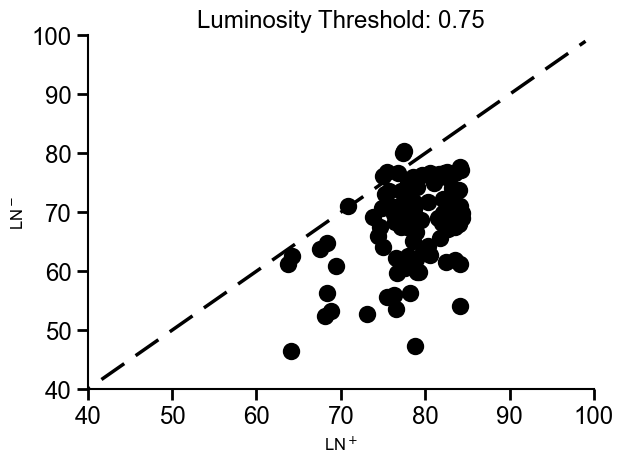

In [46]:
fig, ax = plt.subplots()

cmap = plt.get_cmap('viridis')


top_n = len(runs_dict["runs_vanilla_dann"])

for top in range(top_n):

    vanilla_dann_acc = runs_dict["runs_vanilla_dann"][top].summary['test_acc']

    for rn in runs_dict["runs_vanilla_dann_layernorm"]:
        if same_config(rn.config, runs_dict["runs_vanilla_dann"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum', 'homeostasis']):
            plt.scatter(rn.summary['test_acc'], vanilla_dann_acc, color="black")




ax.set_xlabel(f"LN$^+$")
ax.set_ylabel("LN$^-$")
ax.set_title(f"Luminosity Threshold: {bright_factor}")
list_line = range(100)
ax.set_xlim(40, 100)
ax.set_ylim(40, 100)
ax.plot(list_line, list_line, label='y = x', color='black', linestyle='--')

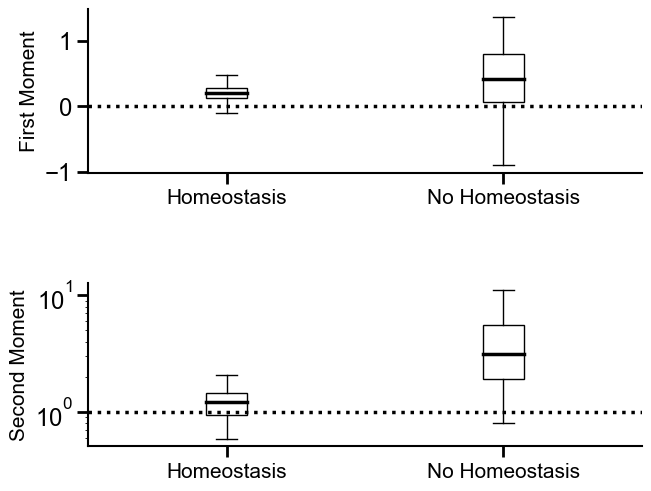

In [71]:
fig = plt.figure(layout="constrained")

plt.rcParams['figure.constrained_layout.use'] = False


gs1 = gridspec.GridSpec(2, 1, figure=fig)
ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs1[1])

mu_dann = []

mu_dann.append([run_van.summary['eval_fc1_mu'] for run_van in runs_dict["runs_homeostasis"]])

mu_dann.append([run_van.summary['eval_fc1_mu'] for run_van in runs_dict["runs_vanilla_dann"]])

var_dann = []

var_dann.append([run_van.summary['eval_fc1_var'] for run_van in runs_dict["runs_homeostasis"]])

var_dann.append([run_van.summary['eval_fc1_var'] for run_van in runs_dict["runs_vanilla_dann"]])


ax1.boxplot(np.array(mu_dann).T, patch_artist=True, boxprops=dict(color='black', facecolor='none'), medianprops=dict(linestyle='-', linewidth=2.5, color='black'),
                            showfliers=False)

ax2.boxplot(np.array(var_dann).T, patch_artist=True, boxprops=dict(color='black', facecolor='none'), medianprops=dict(linestyle='-', linewidth=2.5, color='black'),
                            showfliers=False)

# Create custom x-axis tick labels
custom_xticks = ["Homeostasis", "No Homeostasis"]
ax1.set_xticks(np.arange(1, len(custom_xticks) + 1))
ax1.set_xticklabels(custom_xticks, fontsize=15)
ax1.axhline(y=0, color='black', linestyle='dotted')
ax2.set_xticks(np.arange(1, len(custom_xticks) + 1))
ax2.set_xticklabels(custom_xticks, fontsize=15)
ax2.axhline(y=1, color='black', linestyle='dotted')

ax1.set_ylabel('First Moment', fontsize=15)
ax2.set_ylabel('Second Moment', fontsize=15)
#ax.legend([bp3["medians"][0]], ['H'], loc='lower left')
ax2.set_yscale('log')

gs1.tight_layout(fig, rect=[0, 0, 0.5, 1.0])

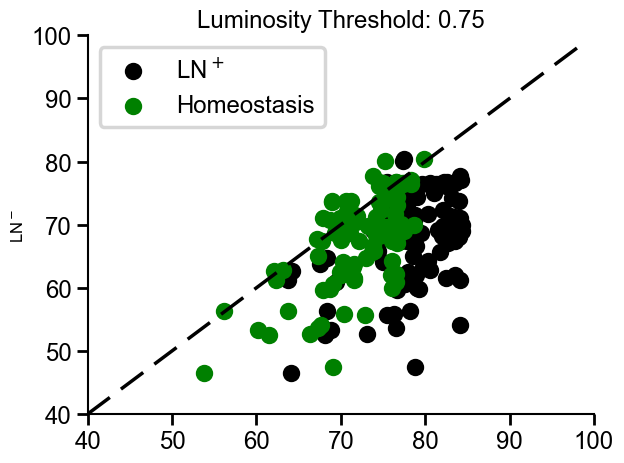

In [90]:
fig, ax = plt.subplots()

cmap = plt.get_cmap('viridis')


top_n = len(runs_dict["runs_vanilla_dann"])

label_flag = True
for top in range(top_n):

    vanilla_dann_acc = runs_dict["runs_vanilla_dann"][top].summary['test_acc']
    for rn in runs_dict["runs_vanilla_dann_layernorm"]:
        if same_config(rn.config, runs_dict["runs_vanilla_dann"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum', 'homeostasis']):
            plt.scatter(rn.summary['test_acc'], vanilla_dann_acc, color="black", alpha=1, label=f"LN$^+$" if label_flag else None)
            label_flag = False

label_flag = True
for top in range(top_n):

    vanilla_dann_acc = runs_dict["runs_vanilla_dann"][top].summary['test_acc']
    for rn in runs_dict["runs_homeostasis"]:
        if same_config(rn.config, runs_dict["runs_vanilla_dann"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum']):
            plt.scatter(rn.summary['test_acc'], vanilla_dann_acc, color="green", label=f"Homeostasis" if label_flag else None)
            label_flag = False



#ax.set_xlabel(f"LN$^+$")
ax.set_ylabel("LN$^-$")
ax.set_title(f"Luminosity Threshold: {bright_factor}")
list_line = range(100)
ax.set_xlim(40, 100)
ax.set_ylim(40, 100)
ax.plot(list_line, list_line, color='black', linestyle='--')
ax.legend()

/tmp/ipykernel_2598001/321194908.py:37: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(range(len(noln_acc)), noln_acc, yerr=noln_err, fmt='-o', linestyle='--', label='LN$^-$', capsize=5, color='#eb3920')


Text(0, 0.5, 'Median Accuracy (Top 10 architectures)')

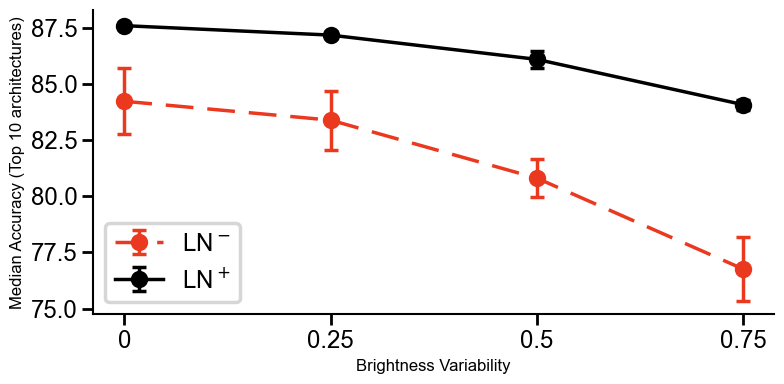

In [7]:
fig, ax = plt.subplots(figsize=(8, 4))
brightness_factor = [0, 0.25, 0.5, 0.75]
noln_acc = []
ln_acc = []
homeo_inhib_acc = []
noln_err = []
ln_err = []
homeo_inhib_err = []

top_n_architectures = 10

for bf in brightness_factor:

    runs_vanilla_dann = fetch_runs(api, entity='project_danns', project_name='Luminosity_NAISYS', filters={"config.dataset": "fashionmnist", 
                                                                "config.brightness_factor": bf, "config.homeostasis": 0, "config.normtype": 0,
                                                                "config.use_testset": True}, order="-summary_metrics.test_acc")[:top_n_architectures]
    runs_vanilla_dann_layernorm = fetch_runs(api, entity='project_danns', project_name='Luminosity_NAISYS', filters={"config.dataset": "fashionmnist", 
                                                                "config.brightness_factor": bf, "config.homeostasis": 0, "config.normtype": 1,
                                                                "config.use_testset": True}, order="-summary_metrics.test_acc")[:top_n_architectures]
    runs_homeostasis = fetch_runs(api, entity='project_danns', project_name='Luminosity_NAISYS', filters={"config.dataset": "fashionmnist", 
                                                                    "config.brightness_factor": bf,"config.homeostasis": 1, "config.normtype": 0,
                                                                    "config.use_testset": True, "config.task_opt_inhib": 1, "config.use_sep_bias_gain_lrs": 0,
                                                                    "config.homeostatic_annealing": 0, "config.implicit_homeostatic_loss": 0 }, order="-summary_metrics.test_acc")[:top_n_architectures]
    
                                                                
    noln_acc.append(np.median([run_noln.summary['test_acc'] for run_noln in runs_vanilla_dann ]))
    ln_acc.append(np.median([run_ln.summary['test_acc'] for run_ln in runs_vanilla_dann_layernorm]))
    homeo_inhib_acc.append(np.median([run_ln.summary['test_acc'] for run_ln in runs_homeostasis]))
    noln_err.append(np.std([run_noln.summary['test_acc'] for run_noln in runs_vanilla_dann ]))
    ln_err.append(np.std([run_ln.summary['test_acc'] for run_ln in runs_vanilla_dann_layernorm]))
    homeo_inhib_err.append(np.std([run_ln.summary['test_acc'] for run_ln in runs_homeostasis]))

# ax.plot(range(len(noln_acc)), noln_acc, color='red')
# ax.plot(range(len(homeo_inhib_acc)), homeo_inhib_acc, color='blue')


ax.errorbar(range(len(noln_acc)), noln_acc, yerr=noln_err, fmt='-o', linestyle='--', label='LN$^-$', capsize=5, color='#eb3920')
#ax.errorbar(range(len(homeo_inhib_acc)), homeo_inhib_acc, yerr=homeo_inhib_err, fmt='-o', label='Homeostasis', capsize=5, color='green')
ax.errorbar(range(len(ln_acc)), ln_acc, yerr=ln_err, fmt='-o',  label='LN$^+$', capsize=5, color='black')
plt.xticks(range(len(noln_acc)), [str(ele) for ele in brightness_factor])
plt.legend()


ax.set_xlabel('Brightness Variability')
ax.set_ylabel(f'Median Accuracy (Top {top_n_architectures} architectures)')




wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.


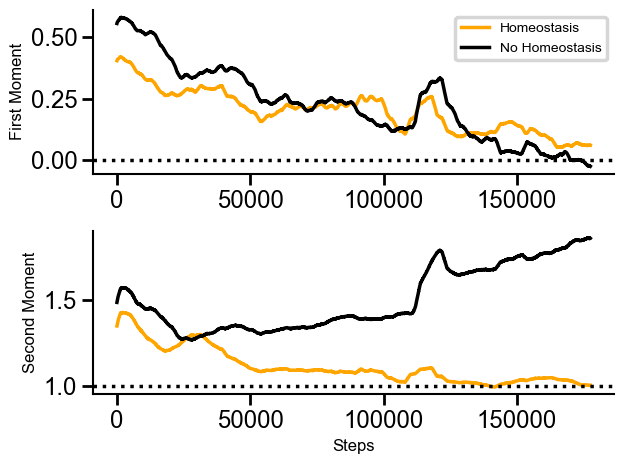

In [13]:
# NOTE: Take long to run

import matplotlib.gridspec as gridspec

plt.close('all')
fig = plt.figure()

gs1 = gridspec.GridSpec(2, 1)
ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs1[1])

best_n_runs = 1
first_moment = []
second_moment = []

for idx, run in enumerate(runs_dict["runs_homeostasis"][:best_n_runs]):
    first_val = []
    second_val = []
    for row in run.scan_history(keys=["train_fc1_mu", "train_fc1_var"]):
        first_val.append(row["train_fc1_mu"])
        second_val.append(row["train_fc1_var"])
    first_moment.append(first_val)
    second_moment.append(second_val)

first_moment = np.mean(first_moment, axis=0)
second_moment = np.mean(second_moment, axis=0)

# Moving average with a window of 5,000
window_size = 10000
first_moment = np.convolve(first_moment, np.ones(window_size)/window_size, mode='valid')
second_moment = np.convolve(second_moment, np.ones(window_size)/window_size, mode='valid')

ax1.plot(first_moment, color='orange', label="Homeostasis" if idx==0 else None)
ax2.plot(second_moment, color='orange', label="Second Moment" if idx==0 else None)

ax2.set_xlabel("Steps")
ax1.set_ylabel("First Moment")
ax2.set_ylabel("Second Moment")

ax1.axhline(y=0, color='black', linestyle='dotted')
ax2.axhline(y=1, color='black', linestyle='dotted')

# Section: No Homeostasis

best_n_runs = 1
no_homeostasis_first_moment = []
no_homeostasis_second_moment = []

for idx, run in enumerate(runs_dict["runs_vanilla_dann"][:best_n_runs]):
    first_val = []
    second_val = []
    for row in run.scan_history(keys=["train_fc1_mu", "train_fc1_var"]):
        first_val.append(row["train_fc1_mu"])
        second_val.append(row["train_fc1_var"])
    no_homeostasis_first_moment.append(first_val)
    no_homeostasis_second_moment.append(second_val)

no_homeostasis_first_moment = np.mean(no_homeostasis_first_moment, axis=0)
no_homeostasis_second_moment = np.mean(no_homeostasis_second_moment, axis=0)

# Moving average with a window of 5,000
window_size = 10000
no_homeostasis_first_moment = np.convolve(no_homeostasis_first_moment, np.ones(window_size)/window_size, mode='valid')
no_homeostasis_second_moment = np.convolve(no_homeostasis_second_moment, np.ones(window_size)/window_size, mode='valid')

ax1.plot(no_homeostasis_first_moment, color='black', label="No Homeostasis" if idx==0 else None)
ax2.plot(no_homeostasis_second_moment, color='black', label="Second Moment" if idx==0 else None)

ax1.legend(fontsize='small')

gs1.tight_layout(fig)